# FINAL NPxZxD PROTOTYPE

In [1]:
from IPython.display import Image
#Image(filename=('NPxZxDslab_schematics.png'), width=500)

In [2]:
import numpy as np
# to check for array handling errors:
np.warnings.filterwarnings('error', category=np.VisibleDeprecationWarning)

import matplotlib.pyplot as plt

# Parameter helping functions (Size Arrays & Allometries)

In [3]:
PZ_num = 10

phyto_init = np.tile(.01, (PZ_num))

zoo_init = np.tile(.005, (PZ_num))

In [4]:
def calculate_sizes(size_min, size_max, num):
    """initializes log spaced array of sizes from ESD size range"""
    numbers = np.array([i for i in range(num)])
    sizes = (np.log(size_max) - np.log(size_min))* numbers / (num-1) + np.log(size_min)
    return np.exp(sizes)

In [5]:
phyto_sizes = calculate_sizes(1,20,PZ_num)
phyto_sizes

array([ 1.        ,  1.39495079,  1.94588772,  2.71441762,  3.78647901,
        5.2819519 ,  7.368063  , 10.27808533, 14.33742329, 20.        ])

In [6]:
zoo_sizes = calculate_sizes(2.16,280,PZ_num)
zoo_sizes

array([  2.16      ,   3.70850331,   6.36712815,  10.9317203 ,
        18.7686671 ,  32.22391856,  55.3252355 ,  94.98787921,
       163.08465954, 280.        ])

In [7]:
def calculate_zoo_I0(sizes):
    """initializes allometric parameters based on array of sizes (ESD)"""
    return 26 * sizes ** -0.4 #* .5

zoo_I0 = calculate_zoo_I0(zoo_sizes)
zoo_I0

array([19.10697113, 15.39195835, 12.39926413,  9.9884464 ,  8.04636956,
        6.48189524,  5.22160529,  4.20635644,  3.38850479,  2.72966993])

In [8]:
def calculate_phyto_mu0(sizes):
    """initializes allometric parameters based on array of sizes (ESD)
    allometric relationships are taken from meta-analyses of lab data"""
    return 2.6 * sizes ** -0.45
    
phyto_mu0 = calculate_phyto_mu0(phyto_sizes)
phyto_mu0

array([2.6       , 2.23831831, 1.92694957, 1.65889481, 1.42812871,
       1.22946409, 1.05843538, 0.91119819, 0.78444292, 0.67532037])

In [9]:
def calculate_phyto_ks(sizes):
    return sizes * .1

phyto_ks = calculate_phyto_ks(phyto_sizes)
phyto_ks

array([0.1       , 0.13949508, 0.19458877, 0.27144176, 0.3786479 ,
       0.52819519, 0.7368063 , 1.02780853, 1.43374233, 2.        ])

In [10]:
def init_phiP(phytosize, preyoptsize):
    """creates array of feeding preferences [P...P10] for each [Z]"""
    phiP = np.array([[np.exp(-((np.log10(xpreyi) - np.log10(xpreyoptj)) / 0.25) ** 2)
                      for xpreyi in phytosize] for xpreyoptj in preyoptsize])
    return phiP

phiP = init_phiP(phyto_sizes, phyto_sizes)
phiP

array([[1.00000000e+00, 7.15798658e-01, 2.62520679e-01, 4.93307727e-02,
        4.74956764e-03, 2.34299842e-04, 5.92204460e-06, 7.66925382e-08,
        5.08881085e-10, 1.73006040e-12],
       [7.15798658e-01, 1.00000000e+00, 7.15798658e-01, 2.62520679e-01,
        4.93307727e-02, 4.74956764e-03, 2.34299842e-04, 5.92204460e-06,
        7.66925382e-08, 5.08881085e-10],
       [2.62520679e-01, 7.15798658e-01, 1.00000000e+00, 7.15798658e-01,
        2.62520679e-01, 4.93307727e-02, 4.74956764e-03, 2.34299842e-04,
        5.92204460e-06, 7.66925382e-08],
       [4.93307727e-02, 2.62520679e-01, 7.15798658e-01, 1.00000000e+00,
        7.15798658e-01, 2.62520679e-01, 4.93307727e-02, 4.74956764e-03,
        2.34299842e-04, 5.92204460e-06],
       [4.74956764e-03, 4.93307727e-02, 2.62520679e-01, 7.15798658e-01,
        1.00000000e+00, 7.15798658e-01, 2.62520679e-01, 4.93307727e-02,
        4.74956764e-03, 2.34299842e-04],
       [2.34299842e-04, 4.74956764e-03, 4.93307727e-02, 2.62520679e-01,
   

# Model building

In [11]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [12]:
from phydra.components.variables import SV, SVArray


from phydra.components.fluxes.grazing import (HollingTypeIII_ResourcesListInput_Consumption2Group,
                                              SizebasedGrazingKernel_Dims,
                                              GrossGrowthEfficiency_MatrixGrazing,
                                              GrossGrowthEfficiency)
from phydra.components.fluxes.ocean_physics import Mixing_K, SlabUpwelling_KfromGroup, SlabMixing_KfromGroup, SlabSinking

from phydra.components.forcings import ConstantForcing


from phydra.components.variables import SV

from phydra.components.fluxes.basic import LinearDecay, LinearExchange, LinearDecay_ListInput
from phydra.components.fluxes.basic_dims import LinearDecay_Dims, QuadraticDecay_Dim_Sum
from phydra.components.fluxes.basic_forcing import LinearForcingInput
from phydra.components.fluxes.growth import MonodGrowth_mu_ConsumerDim

from phydra.components.forcings import ConstantForcing, SinusoidalForcing

In [13]:
ASTroCAT = phydra.create({
    # State variables
    'Nutrient':SV,
    'Phytoplankton':SVArray,
    'Zooplankton':SVArray,
    #'Detritus':SV,
    
    # Flows:
    'Inflow':LinearForcingInput,
    #'Outflow':LinearDecay_ListInput,

    # Growth
    'Growth':MonodGrowth_mu_ConsumerDim,
    
    # Grazing
    'Grazing':SizebasedGrazingKernel_Dims,
    'GGE':GrossGrowthEfficiency_MatrixGrazing,

    # Mortality
    'PhytoMortality':LinearDecay_Dims,
    'ZooMortality':QuadraticDecay_Dim_Sum,
    
    # Forcings
    'N0':ConstantForcing,
                     })

In [14]:
#NPxZxD.visualize()

In [15]:
ASTroCAT

<xsimlab.Model (13 processes, 31 inputs)>
Core
    solver_type              [in]
Time
    time                     [in] ('input_time',) sequence of time ...
Nutrient
    var_label                [in] label / basic state variable
    var_init                 [in] initial value / basic state variable
Phytoplankton
    var_label                [in] label / basic state variable
    var_init                 [in] ('var',) initial value / basic st...
Zooplankton
    var_label                [in] label / basic state variable
    var_init                 [in] ('var',) initial value / basic st...
N0
    forcing_label            [in] label / 
    value                    [in] constant value of forcing
Inflow
    var                      [in] label reference / variable affect...
    forcing                  [in] label reference / forcing affecti...
    rate                     [in] linear rate of change
Growth
    resource                 [in] label reference / 
    consumer                 [in] l

In [16]:
odeint_setup = phydra.setup('odeint', ASTroCAT,
            time=np.arange(0,365*3),  # *365
            input_vars={
                    # State variables
                    'Nutrient':{'var_label':'N','var_init':1.},
                    'Phytoplankton':{'var_label':'P','var_init':phyto_init},
                    'Zooplankton':{'var_label':'Z','var_init':zoo_init},
                
                    # Flows:
                    'Inflow':{'forcing':'N0', 'rate':1., 'var':'N'},
                    #'Outflow':{'var_list':['N', 'P'], 'rate':0.1},
                
                    # Growth
                    'Growth':{'resource':'N', 'consumer':'P', 'halfsat':phyto_ks, 'mu_max':phyto_mu0},

                    # Grazing
                    'Grazing':{'resource':'P', 'consumer':'Z',
                               'Imax':zoo_I0, 'KsZ':3, 'phiP':phiP},
                    'GGE':{'grazed_resource':'P', 'assimilated_consumer':'Z', 'egested_detritus':'N', 
                           'epsilon':0.33, 'f_eg':0.33},
                
                    # Mortality
                    'PhytoMortality':{'var':'P', 'rate':0.1*phyto_mu0},
                    'ZooMortality':{'var':'Z', 'rate':1.},

                    # Forcings
                    'N0':{'forcing_label':'N0', 'value':1.},
            })

In [17]:
with ASTroCAT:
    odeint_out = odeint_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component Zooplankton
Initializing component N0
forcing function is in directory: /Users/bpo/Documents/GitHub/phydra/examples
forcing_val: 1.0
Initializing component Inflow
Initializing component Growth
Initializing component Grazing
Grazing_grazing
Initializing component ZooMortality
Initializing component PhytoMortality
Initializing component GGE
assembling model
SOLVER : <phydra.backend.solvers.ODEINTSolver object at 0x15ee08190>
Model is assembled:
Model contains: 
Variables:['time', 'N', 'P', 'Z'] 
Parameters:['N0_value', 'Inflow_rate', 'Growth_halfsat', 'Growth_mu_max', 'Grazing_phiP', 'Grazing_Imax', 'Grazing_KsZ', 'ZooMortality_rate', 'PhytoMortality_rate', 'GGE_f_eg', 'GGE_epsilon'] 
Forcings:['N0'] 
Fluxes:['Time_time_flux', 'Inflow_input', 'Growth_uptake', 'Grazing_grazing', 'ZooMortality_decay', 'PhytoMortality_decay', 'GGE_grazing', 'GGE_assi

In [27]:
odeint_out.to_zarr('ASTROCAT_OUTPUT.zarr')

In [36]:
.01 * 500

5.0

In [18]:
import xarray as xr

ss = xr.open_zarr('ASTROCAT_OUTPUT.zarr')

ss.Phytoplankton__var_value.plot()

GroupNotFoundError: group not found at path ''

In [ ]:
plt.rcParams['figure.figsize'] = [20, 5]

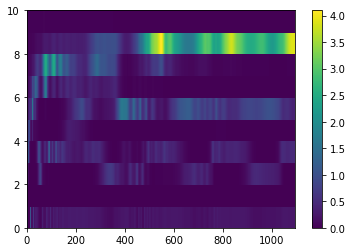

In [19]:
plt.pcolor(odeint_out.Phytoplankton__var_value)
plt.colorbar()

#plt.savefig('ASTroCAT_PZ_200_P.pdf', bbox_inches='tight')
plt.show()

In [ ]:
plt.pcolor(odeint_out.Zooplankton__var_value)
plt.colorbar()

plt.savefig('ASTroCAT_PZ_200_Z.pdf', bbox_inches='tight')
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [5, 7]

#f1, (ax1col, ax1, ax2, ax2col, ax3) = plt.subplots(5, 3, gridspec_kw={'height_ratios': [.1,1,1,.1,1]})#, sharey='row')

fig = plt.figure(constrained_layout=True)

gs = fig.add_gridspec(nrows=5, ncols=3,
                        hspace=0.1, wspace=0.1, height_ratios=[.1,1,1,.1,1])

ax1col = fig.add_subplot(gs[0, 1])
ax1 = fig.add_subplot(gs[1, 0:3])
ax2 = fig.add_subplot(gs[2, 0:3])
ax3col = fig.add_subplot(gs[3, 1])
ax3 = fig.add_subplot(gs[4, 0:3])


plt.setp(ax1, xticks=[1,180,365,365+180,720])
from matplotlib.ticker import MaxNLocator
for axe in [ax1]:
        axe.grid(True, alpha=0.5)
        axe.get_yaxis().set_major_locator(MaxNLocator(nbins=4))
        #axe.tick_params(top=False, right=True, direction="in")

plt.setp((ax2, ax3), xticks=[1,365,2*365,3*365,4*365,5*365,6*365,7*365,8*365,9*365,10*365])
from matplotlib.ticker import MaxNLocator
for axe in (ax2, ax3):  
        axe.grid(True, alpha=0.5)
        axe.get_yaxis().set_major_locator(MaxNLocator(nbins=4))
        #axe.tick_params(top=False, right=True, direction="in")
        
ax1.set_title('Phytoplankton biomass [µM N]')
ax1plt = ax1.pcolormesh(P_out.time[:365*2*resolution:resmpl_step],P_out.P__sizes,
               P_out.env__stateout[:365*2*resolution:resmpl_step].T, linewidth=0,rasterized=True)
ax1plt
ax1.set_yscale('log')
ax1.set_yticks([1,2,5,10,20])
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.colorbar(ax1plt,cax=ax1col, orientation='horizontal')
ax1.set_ylabel('Phytoplankton ESD [µm]')
ax1.set_xlabel('Time [days]')
    
ax2.pcolormesh(P_out.time[::resolution],P_out.P__sizes,P_out.env__stateout[::resolution].T, linewidth=0,rasterized=True)
ax2.set_yscale('log')
ax2.set_yticks([1,2,5,10,20])
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_ylabel('Phytoplankton ESD [µm]')
ax2.set_xlabel('Time [years]')
ax2.set_xticklabels(labels=[i for i in range(1,11)])

ax3.set_title('Zooplankton biomass [µM N]')
ax3plt = ax3.pcolormesh(Z_out.time[::resolution],Z_out.Z__sizes,Z_out.env__stateout[::resolution].T, linewidth=0,rasterized=True)
ax3plt
ax3.set_yscale('log')
ax3.set_yticks([3,5,10,20,50,100,200,400])
ax3.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.colorbar(ax3plt, cax=ax3col, orientation='horizontal')
ax3.set_ylabel('Zooplankton ESD [µm]')
ax3.set_xlabel('Time [years]')
ax3.set_xticklabels(labels=[i for i in range(1,11)])

# Defining custom 'xlim' and 'ylim' values.
xlim = (0, 365*9+364)

# Setting the values for all axes.
plt.setp((ax2, ax3), xlim=xlim)

#f1.align_ylabels()


plt.savefig('../03_chemostat.pdf', bbox_inches='tight')
plt.show()

In [ ]:
time = odeint_out.Time__time

plt.plot(time, odeint_out.MLD__forcing_value, label='MLD')
plt.ylim(bottom=0)
plt.legend()
plt.show()

plt.plot(time, odeint_out.MLDderiv__forcing_value, label='MLDderiv')
plt.legend()
plt.show()

plt.plot(time, odeint_out.I0__forcing_value, label='I0')
plt.plot(time, odeint_out.N0__forcing_value, label='N0')
plt.plot(time, odeint_out.Tmld__forcing_value, label='Tmld')
plt.ylim(bottom=0)
plt.legend()

In [ ]:
time = odeint_out.Time__time
plt.plot(time, odeint_out.Nutrient__var_value, label='N')
plt.ylim(bottom=0)
plt.legend()

In [ ]:
time = odeint_out.Time__time
plt.plot(time, odeint_out.Nutrient__var_value, label='N')
plt.plot(time, odeint_out.Phytoplankton__var_value.T, label='P')
plt.plot(time, odeint_out.Zooplankton__var_value.T, label='Z')
plt.plot(time, odeint_out.Detritus__var_value, label='D')
plt.ylim(bottom=0)
plt.legend()

In [ ]:
#plt.plot(time, -odeint_out.PhytoLinMortality__decay_value.T, label='P linear mortality')
#plt.plot(time, -odeint_out.PhytoQuadMortality__decay_value.T, label='P quad mortality')
plt.plot(time, odeint_out.Growth__growth_value.T, label='Phyto growth')

plt.legend()

In [ ]:
plt.plot(time, odeint_out.GGE__grazing_value.T, label="grazing")
plt.legend()

In [ ]:
stepwise_setup = phydra.update_setup(model=NPxZxD, old_setup=odeint_setup, new_solver="stepwise",
                                     new_time=np.arange(0,5*365,.2))

In [ ]:
with NPxZxD:
    stepwise_out = stepwise_setup.xsimlab.run()

In [ ]:
time = stepwise_out.Time__time
plt.plot(time, stepwise_out.Nutrient__var_value, label='N')
plt.plot(time, stepwise_out.Phytoplankton__var_value.T, label='P')
plt.plot(time, stepwise_out.Zooplankton__var_value.T, label='Z')
plt.plot(time, stepwise_out.Detritus__var_value, label='D')
#plt.ylim(bottom=0)
plt.legend()

In [ ]:
plt.plot(time, stepwise_out.GGE__grazing_value.T, label="grazing")
plt.legend()

#stepwise_out.GGE__egestion_value

In [ ]:
plt.plot(time, stepwise_out.GGE__assimilation_value[0,:], label="graze 1")
plt.plot(time, stepwise_out.GGE__assimilation_value[1,:], label="graze 2")
plt.plot(time, stepwise_out.GGE__assimilation_value[2,:], label="graze 3")
plt.legend()

In [ ]:
#plt.plot(time, stepwise_out.GGE__grazed_resource)

In [ ]:
# plt.plot(time, stepwise_out.Input__input_value, label='N_input')
# plt.plot(time, -stepwise_out.PhytoLinMortality__decay_value, label='P mortality')
# plt.plot(time, -stepwise_out.PhytoQuadMortality__decay_value, label='P quad mortality')
# plt.plot(time, stepwise_out.Growth__growth_value, label='N uptake')
plt.plot(time, stepwise_out.Grazing__grazing_value[0,0,:], label='Grazing')
plt.plot(time, stepwise_out.Grazing__grazing_value[1,1,:], label='Grazing1')
plt.plot(time, stepwise_out.Grazing__grazing_value[2,2,:], label='Grazing2')
# plt.ylim(bottom=0)
plt.legend()

In [ ]:
gekko_setup = phydra.update_setup(model=NPxZxD, 
                                  old_setup=odeint_setup, 
                                  new_solver="gekko", 
                                  # gekko solver works better (much faster) with smaller time steps:
                                  # new_time=np.arange(0,201,.1)
                                 )

In [ ]:
with NPxZxD:
    gekko_out = gekko_setup.xsimlab.run()

In [ ]:
gekko_out

In [ ]:
time = gekko_out.Time__time
plt.plot(time, gekko_out.Nutrient__var_value, label='N')
plt.plot(time, gekko_out.Phytoplankton__var_value.T, label='P')
plt.plot(time, gekko_out.Zooplankton__var_value.T, label='Z')
plt.plot(time, gekko_out.Detritus__var_value, label='D')
plt.ylim(bottom=0)
plt.legend()

In [ ]:
# GEKKO
time = gekko_out.Time__time
#plt.plot(time, gekko_out.Nutrient__var_value, label='N')

plt.plot(time, gekko_out.Upwelling__mixing_value, label='mixing')
plt.plot(time, gekko_out.MLDderiv__forcing_value/100, label='MLDderiv')
#plt.ylim(bottom=0)
plt.legend()

In [ ]:
_dims = ()

In [ ]:
f"{'(' + ','.join(_dims) + ')'}"

In [ ]:
upwelling1 = (gekko_out.N0__forcing_value - gekko_out.Nutrient__var_value) * (np.maximum(gekko_out.MLDderiv__forcing_value, 0) +gekko_out.Upwelling__kappa) /gekko_out.MLD__forcing_value

In [ ]:
plt.plot(time, upwelling1)

In [ ]:
plt.plot(time, np.maximum(gekko_out.MLDderiv__forcing_value, 0) +gekko_out.Upwelling__kappa, label='mixing')

In [ ]:
# ODEINT
plt.plot(time, odeint_out.Upwelling__mixing_value, label='mixing')

plt.plot(time, odeint_out.MLDderiv__forcing_value/100, label='MLDderiv')
plt.legend()

In [ ]:
time = gekko_out.Time__time
#plt.plot(time, gekko_out.Nutrient__var_value, label='N')

plt.plot(time, gekko_out.Phytoplankton__var_value.T, label='P')
plt.plot(time, gekko_out.MLDderiv__forcing_value, label='MLDderiv')
plt.ylim(bottom=0)
plt.legend()

In [ ]:
plt.plot(time, gekko_out.PhytoLinMortality__decay_value.T, label='P mortality')
plt.plot(time, gekko_out.PhytoQuadMortality__decay_value.T, label='P quad mortality')
plt.plot(time, gekko_out.Growth__growth_value.T, label='N uptake')
#plt.plot(time, gekko_out.Grazing__grazing_value, label='Grazing')
plt.ylim(bottom=0)
plt.legend()